<a href="https://colab.research.google.com/github/vinayhpandya/fastai_labs/blob/master/superres_using_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Super resolution

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
from torchvision.models import vgg16_bn

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [ ]:
il = ImageList.from_folder(path_hr)

In [ ]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [ ]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /root/.fastai/data/oxford-iiit-pet/small-96


resizing to 256 into /root/.fastai/data/oxford-iiit-pet/small-256


In [ ]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [ ]:
data = get_data(bs,size)

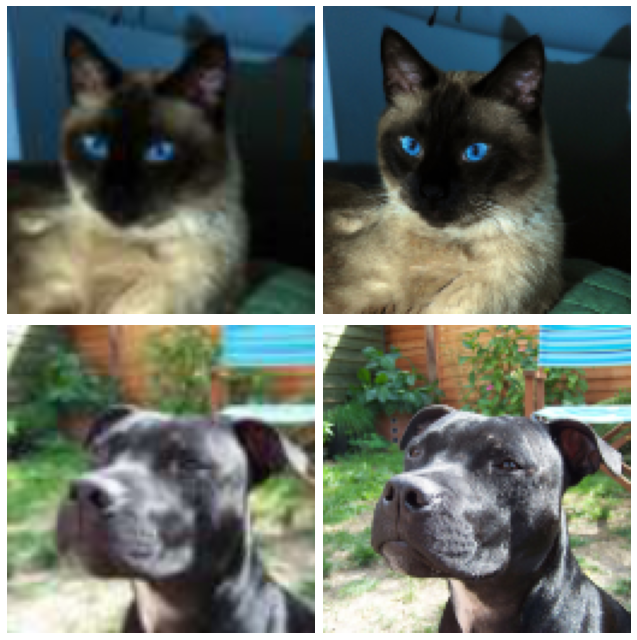

In [ ]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [ ]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
gram_matrix(t)

tensor([[[0.0386, 0.0393, 0.0338],
         [0.0393, 0.0429, 0.0393],
         [0.0338, 0.0393, 0.0382]],

        [[0.0386, 0.0393, 0.0338],
         [0.0393, 0.0429, 0.0393],
         [0.0338, 0.0393, 0.0382]]])

In [ ]:
base_loss = F.l1_loss

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [ ]:
feat_loss

FeatureLoss(
  (m_feat): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

## Train

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


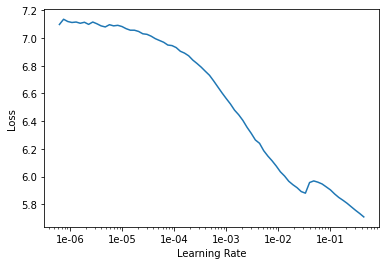

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(4, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.891206,3.674417,0.142036,0.228705,0.314857,0.222034,0.544808,1.196624,1.025355,04:13
1,3.824462,3.689116,0.148678,0.228433,0.315633,0.224174,0.540907,1.191953,1.039339,04:00
2,3.877506,3.701440,0.140830,0.224518,0.312639,0.224553,0.558585,1.202325,1.037989,03:57
3,3.814871,3.595701,0.133624,0.221800,0.305798,0.219090,0.533301,1.165934,1.016154,03:57


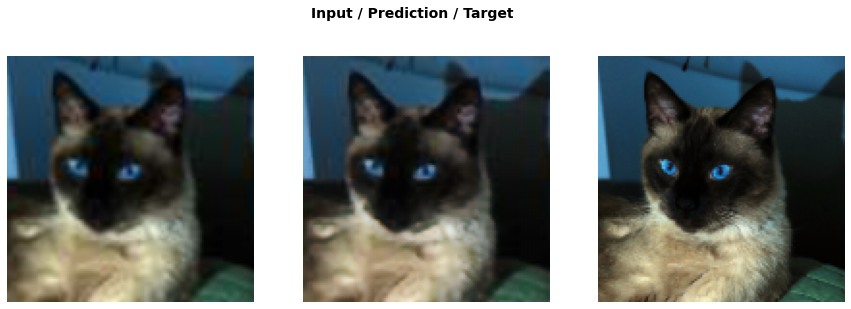

In [ ]:
do_fit('1a', slice(lr*10))

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.762168,3.584899,0.131500,0.221972,0.305421,0.218946,0.530246,1.162816,1.013999,04:09
1,3.757598,3.580968,0.132510,0.221938,0.305155,0.218677,0.528527,1.162136,1.012025,04:09
2,3.748771,3.572229,0.132596,0.221393,0.304634,0.218280,0.524899,1.160098,1.010327,04:08
3,3.753471,3.556039,0.131231,0.221416,0.303932,0.217687,0.520017,1.154051,1.007704,04:08


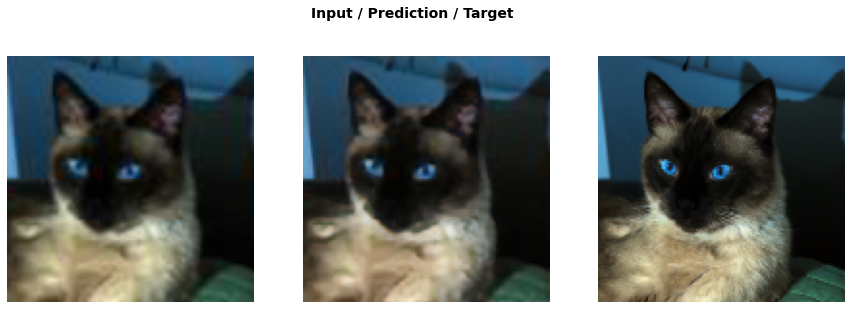

In [ ]:
do_fit('1b', slice(1e-5,lr))

In [ ]:
data = get_data(12,size*2)

In [ ]:
learn.data = data
learn.freeze()
gc.collect()

13657

In [ ]:
learn.load('1b');

In [ ]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


In [ ]:
learn.unfreeze()

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [ ]:
learn = None
gc.collect();

In [ ]:
256/320*1024

819.2

In [ ]:
256/320*1600

1280.0

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(820, 1024), have 6301MB of GPU RAM free


In [ ]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('1b');

FileNotFoundError: ignored

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

In [ ]:
img = open_image(fn); img.shape

In [ ]:
p,img_hr,b = learn.predict(img)

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
Image(img_hr).show(figsize=(18,15))